# **BERTopic sur des transcription de videos**

In [1]:
%%capture

#!pip install safetensors
#%pip install datasets
#%pip install datashader
#%pip install adjustText

In [1]:
import unidecode
unidecode.unidecode("côté")

'cote'

# **La base de donnée**
- Les transcriptions ont été nettoyées en supprimant les mots non important
- Les données sont de format `json` et subdivisées en petit bloc pour calculer les embeddings
- On a le format suivant:
```json
{
    "transcripts": [["tokens1", "etc"], ["token1", "etc"], ...],
}
```

In [2]:
from sentence_transformers import SentenceTransformer
import json
from tqdm.autonotebook import tqdm
from nltk.corpus import stopwords
import numpy as np

In [3]:
additional_stopwords = ["exemple", "problème", "fois", "monde", "foi", "temps",
                        "moment", "jour", "coup", "truc", "côté", "besoin", "ouai", "sen",
                        "faire", "chose","cas", "fois", "temps", "monde", "ouais", "coup", "chose","choses","truc",
                 "moment", "musique", "france", "côté", "fin", "partie", "point", "part", "ans",
                 "monsieur",
                 "être", "etre", "ok", "mot", "idée", "merde", "bout", "soir", "pari",
                 "grâce", "ville", "parti", "discours"]

In [4]:

stopword_french = stopwords.words('french')
stopword_english = stopwords.words('english')
stopword = stopword_french + stopword_english
stopword = set(stopword)
stopword.update(additional_stopwords)

In [5]:
file_path = "../../SpaCy_fr_preprocessed_transcripts_all_years.jsonl"
data = []
with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        data.append(json.loads(line.strip()))

In [6]:
import spacy
nlp = spacy.load("fr_core_news_md")

In [7]:
for d in data:
    d['transcripts'] = [t for t in d['processed_transcripts'] if t not in stopword]

In [8]:
docs = []
for d in tqdm(data):
    transcript = ' '.join(d["processed_transcripts"])
    docs.append(transcript)

  0%|          | 0/15527 [00:00<?, ?it/s]

# **Premier pas avec Bertopic**

- On va illustrer l'entrainement sur une base de donnée en utiliser quelques lignes de codes.
- Plus tard, nous allons explorer la modularité de `Bertopic`

## Embeddings

- Nous pré-calculerons et sauvegarderons les embeddings pour le modèle BERTopic
- Cela nous permet de gagner du temps en évitant cette étape lors des itérations futures sur le modèle.

In [9]:
MPNET = 'sentence-transformers/paraphrase-multilingual-mpnet-base-v2'
MINI_LM = 'sentence-transformers/all-MiniLM-L6-v2'
S_CAMEMBERT = 'dangvantuan/sentence-camembert-base'

In [10]:
# Creation des embeddings
model = SentenceTransformer(MPNET)
embeddings = model.encode(docs, show_progress_bar=True)

Batches:   0%|          | 0/486 [00:00<?, ?it/s]

c:\Users\MahamadiNikiema\anaconda3\envs\data-4-good-paca\lib\site-packages\transformers\models\xlm_roberta\modeling_xlm_roberta.py:371: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Il est recommendé de sauvegarder les embeddings pour ne pas les calculer tout temps:

In [11]:
with open('./mpnet-embeddings.npy', 'wb') as f:
    np.save(f, embeddings)

- On peut les charger en mémoire comme suit:

In [10]:
embeddings = np.load("./mpnet-embeddings.npy")

## Preparation du vocabulaire

L'auteur suggère de préparer le vocabulaire en amont pour économiser de la mémoire avant d'entraîner leur modèle.

Cette étape, bien que facultative avec assez de RAM, peut aider à réduire son utilisation. 

Il recommande aussi d'utiliser un `CountVectorizer` personnalisé plutôt que le `CountVectorizer` par défaut, s'il est disponible.

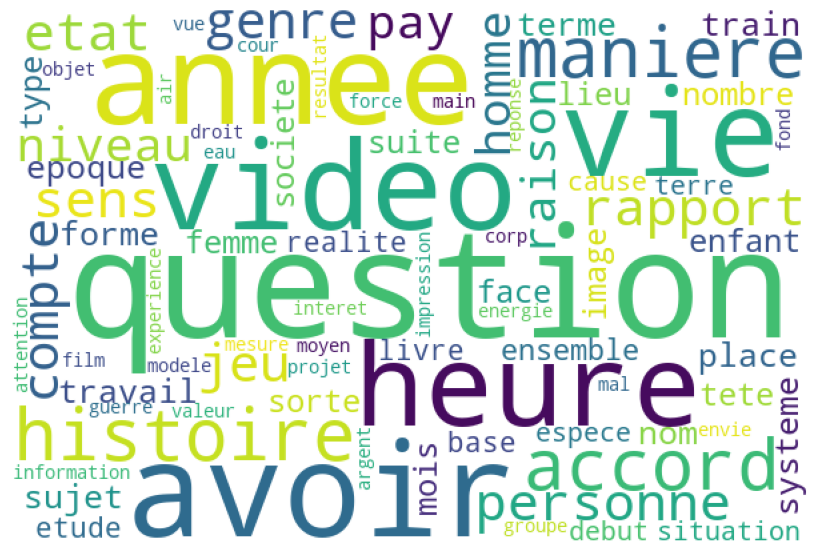

In [12]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

text = ' '.join(docs)

wordcloud = WordCloud(width = 600, height = 400, 
                background_color ='white', 
                stopwords = stopword, 
                min_font_size = 10).generate(text)

# Plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [13]:
import collections
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer

# Construction du vocabulaire
all_vocab = collections.Counter()
tokenizer = CountVectorizer().build_tokenizer()
for doc in tqdm(docs):
  all_vocab.update(tokenizer(doc))

100%|██████████| 15527/15527 [00:05<00:00, 2839.55it/s]


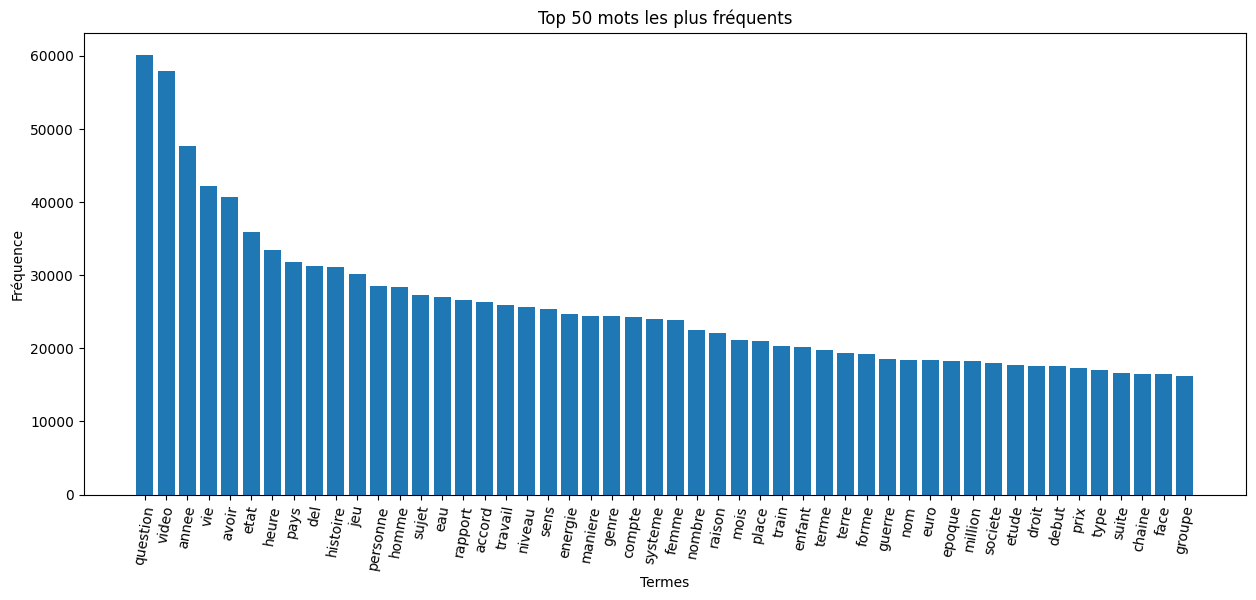

In [14]:
import matplotlib.pyplot as plt

top_n = 50
most_common_words = all_vocab.most_common(top_n)

# Separate the words and their frequencies
words, frequencies = zip(*most_common_words)

# Create a bar plot

plt.figure(figsize=(15,6))
plt.bar(words, frequencies)
plt.xlabel('Termes')
plt.ylabel('Fréquence')
plt.title('Top ' + str(top_n) +' mots les plus fréquents')
plt.xticks(rotation=80)
plt.show()

- On peut ainsi voir le nombre de mots dans notre vocabulaire

In [15]:
# On garde les mots dont la fréquence est supérieur à 15
vocab = [word for word, frequency in all_vocab.items() if frequency >= 15 and frequency < 9000]

In [16]:
len(vocab)

50319

## Entrainement de `BERTopic`

Nous pouvons entraîner notre modèle `BERTopic`.

Nous sélectionnons un modèle d'embeddings de phrases de la librairie SentenceTransformer et nous choisissons les modèles `HDBSCAN` et `UMAP`. 

Nvidia a développé des versions accélérées par GPU de `HDBSCAN` et `UMAP`, ce qui permet d'améliorer l'entraînement sur un ensemble de données aussi volumineux.

In [17]:
from umap import UMAP
import hdbscan
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired

# Preparation des modèles

#
embedding_model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')
# UMAP
umap_model = UMAP(n_components=10, n_neighbors=30, random_state=42,
                  metric="cosine", verbose=True)
# HDBSCAN
hdbscan_model = hdbscan.HDBSCAN(min_samples=20, gen_min_span_tree=True,
                                prediction_data=True, min_cluster_size=20)
# Vectorizer
vectorizer_model = CountVectorizer(vocabulary=vocab, stop_words=list(stopword))

# Fit BERTopic without actually performing any clustering
topic_model= BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        verbose=True,
        representation_model= KeyBERTInspired(),
        # nr_topics=8
).fit(docs, embeddings=embeddings)

2025-02-08 11:28:12,228 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


UMAP(angular_rp_forest=True, metric='cosine', n_components=10, n_jobs=1, n_neighbors=30, random_state=42, verbose=True)
Sat Feb  8 11:28:12 2025 Construct fuzzy simplicial set
Sat Feb  8 11:28:12 2025 Finding Nearest Neighbors
Sat Feb  8 11:28:12 2025 Building RP forest with 11 trees
Sat Feb  8 11:28:16 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	Stopping threshold met -- exiting after 5 iterations
Sat Feb  8 11:28:32 2025 Finished Nearest Neighbor Search
Sat Feb  8 11:28:35 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Feb  8 11:28:49 2025 Finished embedding


2025-02-08 11:28:49,699 - BERTopic - Dimensionality - Completed ✓
2025-02-08 11:28:49,700 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-02-08 11:28:51,080 - BERTopic - Cluster - Completed ✓
2025-02-08 11:28:51,091 - BERTopic - Representation - Extracting topics from clusters using representation models.
c:\Users\MahamadiNikiema\anaconda3\envs\data-4-good-paca\lib\site-packages\bertopic\vectorizers\_ctfidf.py:82: RuntimeWarning: divide by zero encountered in divide
  idf = np.log((avg_nr_samples / df) + 1)
2025-02-08 11:29:07,992 - BERTopic - Representation - Completed ✓


Nous pouvons examiner les sujets comme suit :

In [18]:
topic_info = topic_model.get_topic_info()

In [19]:
topic_info

Topic  Count                                               Name  \
0      -1   9188                 -1_francais_matiere_travers_erreur   
1       0    640        0_republique_francois_francais_larepublique   
2       1    613                  1_youtube_youtuber_oeuvre_contenu   
3       2    496               2_relativite_gravite_univers_galaxie   
4       3    416      3_climat_changementclimatique_matiere_secteur   
5       4    390                   4_ukrainien_ukraine_russie_russe   
6       5    346                 5_vaccinale_vaccin_vaccine_variole   
7       6    235                6_inflation_economiste_taux_monnaie   
8       7    197             7_reacteur_nucleaire_allemagne_fission   
9       8    192   8_paleontologue_paleontologie_hominide_mammifere   
10      9    187                  9_francais_soiree_chanson_matiere   
11     10    173          10_intelligence_conversation_chatbot_chat   
12     11    154                 11_lefilm_cinema_scene_blockbuster   
13     12    128                  12_francais_gaulois_gaule_travers   
14     13    121           13_lesfemme_leshomme_feministe_feminisme   
15     14    117               14_medecine_soignant_patient_medecin   
16     15    113                  15_anguille_troupeau_ruche_chauve   
17     16    103          16_environnement_secteur_ecologie_matiere   
18     17    103      17_mathematique_mathematicien_propriete_carre   
19     18    100           18_reflexion_etudiant_revue_scientifique   
20     19     84  19_interpellation_republique_presomption_plaig...   
21     20     73              20_cuisinier_assiette_bouillon_pastis   
22     21     69                21_podcast_podcasts_ecoute_auditeur   
23     22     66                    22_gamestop_gameplay_games_game   
24     23     64        23_israelien_palestinien_palestine_sionisme   
25     24     62          24_bitcoinet_bitcoin_cryptomonnaie_crypto   
26     25     59           25_depression_deprime_depressionc_delire   
27     26     51        26_conference_thematique_langue_bourgeoisie   
28     27     49     27_cyber_cyberpunk_cybersecurite_cybercriminel   
29     28     49                   28_taiwan_chinois_xinjiang_chine   
30     29     48               29_monnaie_entite_environnement_vert   
31     30     48           30_nourriture_aliment_alimentation_steak   
32     31     47                31_muscle_biceps_musculation_tendon   
33     32     44          32_jugement_raisonnement_inference_erreur   
34     33     44          33_cancereux_cancer_tumeur_chimiotherapie   
35     34     42         34_avortement_grossesseet_grossesse_uterus   
36     35     40                   35_jardin_petale_plante_conifere   
37     36     39    36_anarchisme_ideologie_anarchiste_bonapartisme   
38     37     36               37_francais_propos_syndicalisme_tele   
39     38     35                     38_internaute_internet_web_net   
40     39     35          39_allemagne_francais_autriche_autrichien   
41     40     34                  40_propos_individu_erreur_qualite   
42     41     32           41_facebook_message_plateforme_instagram   
43     42     28                42_francais_vpn_langue_linguistique   
44     43     28                  43_violence_viol_menace_agression   
45     44     28                44_notrecerveau_lobe_cortex_neurone   
46     45     27               45_porteavion_francais_avion_planeur   
47     46     25             46_leshomme_youtubeur_lesfemme_youtube   
48     47     25                   47_bible_jehovisme_verset_psaume   
49     48     25  48_espritcritique_philosophe_philosophie_refle...   
50     49     25                    49_jardin_vigne_potager_haricot   
51     50     24                         50_jaoui_sayan_pote_ordure   
52     51     23                 51_racialisme_racisme_raciste_race   
53     52     22                 52_gene_mutagenese_mutation_genome   
54     53     22               53_mythologie_romain_antiquite_mythe   
55     54     22            

- Coherence: The coherence of a topic is the average similarity between words in the topic.
- Diversity: The diversity is the proportion of unique topics words.

All these metrics is less than 1. 

In [ ]:
from octis.evaluation_metrics.coherence_metrics import Coherence
from octis.evaluation_metrics.diversity_metrics import TopicDiversity

In [35]:
topics = topic_info[topic_info["Topic"] != -1]["Topic"]
topic_list = []
for topic in topics:
    topic = topic_model.get_topic(topic)
    topic_list.append([word[0] for word in topic])

In [40]:
topics_docs = topic_info[topic_info["Topic"] != -1]["Representative_Docs"]

In [56]:
from typing import TypedDict, List

class TopicInfo(TypedDict):
    topics: List[List[str]]
    docs: List[List[str]]


class EvalScore(TypedDict):
    coherence_npmi: float
    coherence_cv: float
    diversity: float


In [57]:
from functools import partial

def evaluator(topics: TopicInfo, topk: int = 10) -> EvalScore:
    partial_coherence = partial(Coherence, texts=topics["docs"], topk=topk)
    coherence_npmi = partial_coherence().score(topics)
    coherence_cv = partial_coherence(measure="c_v").score(topics)
    diversity = TopicDiversity().score(model_output=topics)
    return EvalScore(coherence_cv=coherence_cv, coherence_npmi=coherence_npmi,
                     diversity=diversity)

In [58]:
topic_inf = TopicInfo(topics=topic_list, docs=[doc.split() for doc in docs])

eval_res = evaluator(topic_inf)
eval_res

{'coherence_cv': 0.5601188714520002,
 'coherence_npmi': 0.03638319809391551,
 'diversity': 0.787719298245614}

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import math

In [27]:
def visualize_topics(model_method: pd.DataFrame, n_topics: int = 17) -> None:
    """
    Visualizes topics generated by a topic modeling method using word clouds.
    """
    # Create subplots for each topic
    model_method = model_method.head(n_topics)
    topic_num = model_method.shape[0]
    ncols = 5
    fig_width = 30
    fig_height = 18
    nrows = math.ceil(topic_num / ncols)
    fig, axes = plt.subplots(
        nrows=nrows, ncols=5, figsize=(fig_width, fig_height), sharex=True, sharey=True
    )
    axes = axes.flatten()

    for idx in range(topic_num):
        rep = model_method.iloc[idx]["Representative_Docs"]
        wordcloud = WordCloud(background_color="white", colormap="viridis").generate(
            " ".join(rep)
        )
        ax = axes[idx]
        ax.imshow(wordcloud, interpolation="bilinear")
        ax.set_title(f"Topic {idx + 1}", fontsize=16)
        ax.axis("off")

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.show()

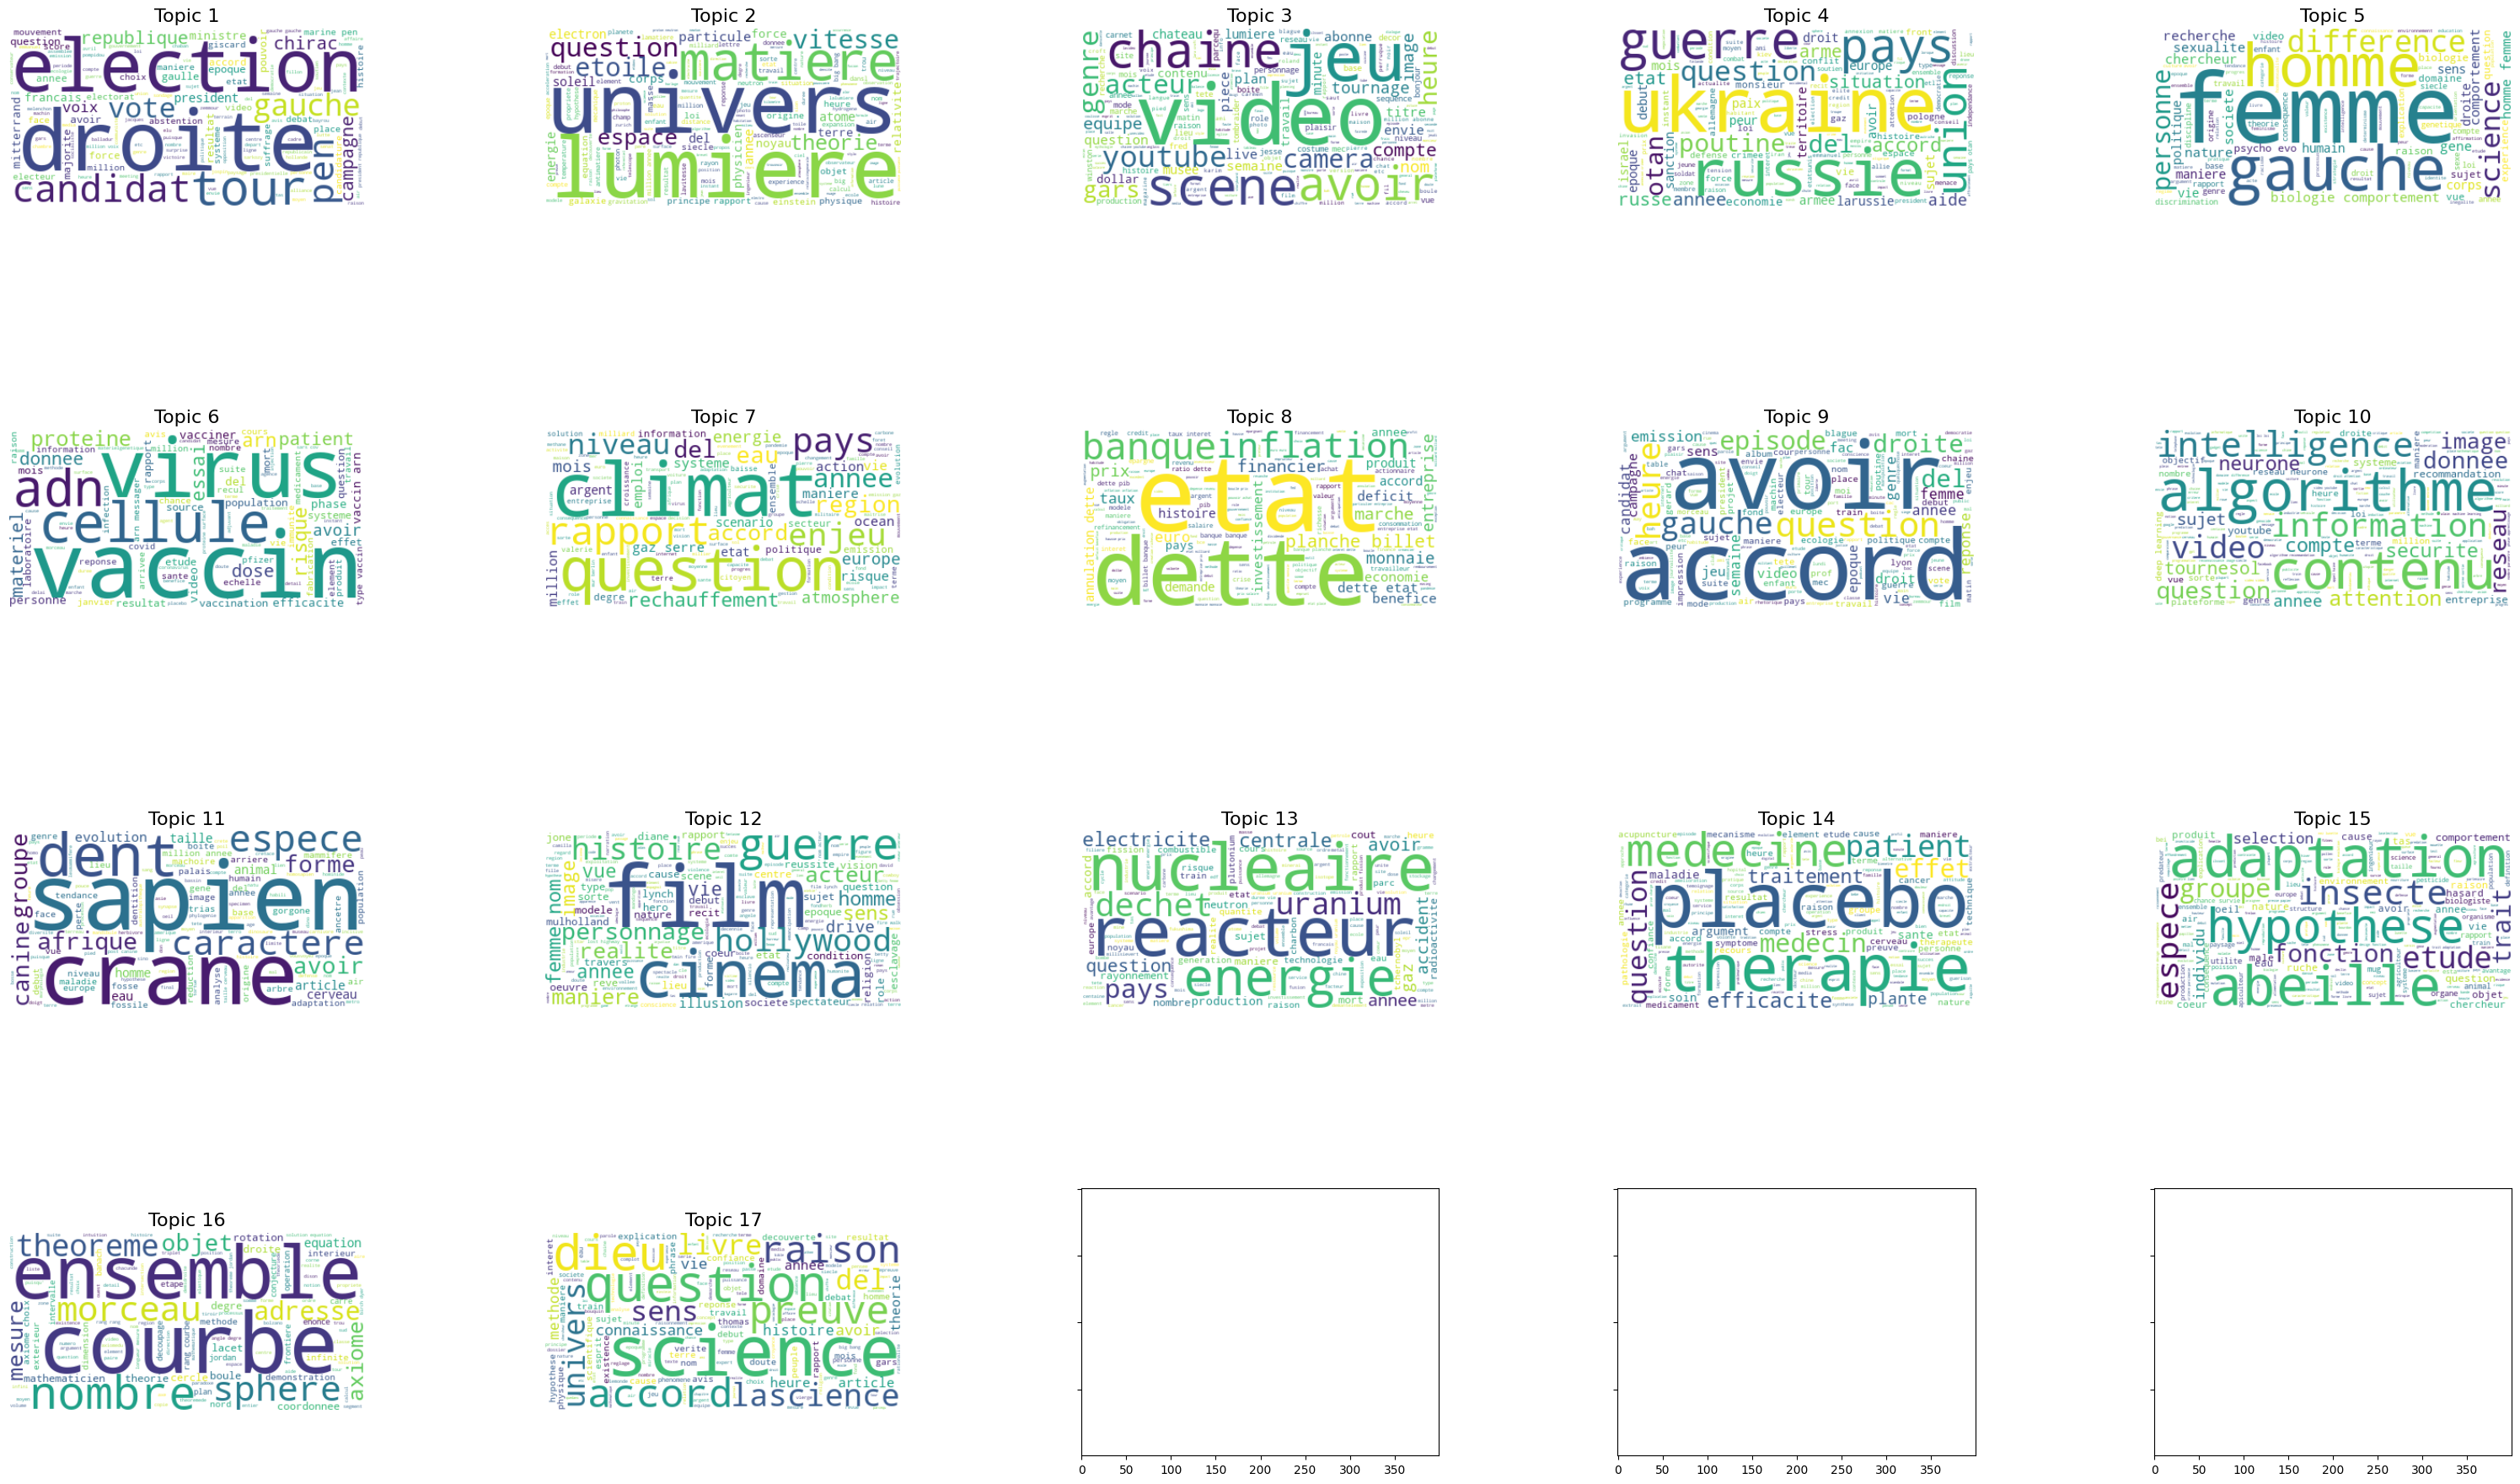

In [28]:
visualize_topics(topic_rep)

## Visualisation des thèmes
### Diagramme en barre

In [29]:
topic_model.visualize_barchart(top_n_topics=40, n_words=10)

In [30]:
topic_model.visualize_topics()

### Visualiser la hiérarchie des thèmes

- Certaines thématiques sont en fait des sous-thèmes d'autres thématiques.
- Comprendre la hiérarchie permet de déterminer quelles thématiques devraient être fusionnées et lesquelles ne le devraient pas.

In [31]:
hierarchical_topics = topic_model.hierarchical_topics(docs)

100%|██████████| 53/53 [00:19<00:00,  2.78it/s]


In [32]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [67]:
import pandas as pd

df = pd.read_csv("../../data/dataset.csv")

In [87]:
example = df.loc[10, "transcript"]

In [93]:
import textwrap

textwrap.wrap(example, width=100)

['attention sujet sensible -ce mettre assiette sûr débat ami famille manque info scientifique impact',
 "environnement manger co2 bien sûr impact limite planétaire bien aujourd'hui résumé meilleur papier",
 'recherche meilleur méta-analyse scientifique beal graphique Musique liste entendre sujet vite perdre',
 'falloir manger viande produit laitier local zéro déchet bio saison tomate avocat attention café',
 'gaspillage alimentaire idem falloir ok truc vrai beaucoup tri poser moi question vouloir question',
 'impact manger climat bon commencer base vrai question arriver niveau mondial production nourriture',
 'représenter 26 émission gaz serre quart France 10 tonne total empreinte carbone moyen habitant',
 'alimentation représenter 2,35 tonne secteur émetteur déplacement logement achat rappeler limiter',
 'réchauffement global maximum degré falloir 2 tonne habitant ici 2050 instant moyenne français rien',
 'manger dépasser manger gros rectangle loin viande compte 0,9 tonne ok aller loi

In [94]:
import spacy

nlp = spacy.load("fr_core_news_md")
example_doc = nlp(example)
example = " ".join([token.lemma_ for token in example_doc if not (token.is_stop or token.is_punct or token.is_digit or token.text in stopword)])

In [95]:
topic_model.transform(documents=[example])

Batches: 100%|██████████| 1/1 [00:00<00:00, 10.11it/s]
2024-06-16 16:27:33,855 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
Epochs completed: 100%| ██████████ 100/100 [00:00]
2024-06-16 16:27:34,554 - BERTopic - Dimensionality - Completed ✓
2024-06-16 16:27:34,554 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2024-06-16 16:27:34,556 - BERTopic - Cluster - Completed ✓


	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs


([5], array([0.90742637]))

In [37]:
def fit_bertopic_model(docs=docs, embeddings=embeddings, vocab=vocab, stopword=stopword, 
                       embedding_model_name=MINI_LM, representation_model=None, y=None):
    """
    Fits a BERTopic model with custom configurations.

    :param docs: List of documents to fit the model.
    :param embeddings: Pre-computed embeddings for the documents.
    :param vocab: Vocabulary for the CountVectorizer.
    :param stopword: List of stopwords.
    :param embedding_model_name_or_instance: The name of the embedding model or an already initialized model instance.
    :return: Fitted BERTopic model.
    """
    # Load or use the provided sentence transformer model
    
    embedding_model = SentenceTransformer(embedding_model_name)

    # Initialize UMAP
    umap_model = UMAP(n_components=5, n_neighbors=50, random_state=42,
                      metric="euclidean", verbose=True)

    # Initialize HDBSCAN
    hdbscan_model = hdbscan.HDBSCAN(min_samples=20, gen_min_span_tree=True,
                                    prediction_data=True, min_cluster_size=20)

    # Initialize CountVectorizer
    vectorizer_model = CountVectorizer(vocabulary=vocab, stop_words=list(stopword))

    # Fit BERTopic
    topic_model = BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        verbose=True,
        representation_model=representation_model
    ).fit(docs, embeddings=embeddings)

    return topic_model


Enfin, on sauvegarder le modèle de la manière suivante :

In [33]:
topic_model.save(
    path='./models/bert_topic_model',
    serialization="safetensors",
    save_ctfidf=True,
    save_embedding_model=True,
)

De même, nous pouvons également préparer les embeddings réduits par `UMAP` pour la visualisation de documents en 2D:

In [27]:
from umap import UMAP

# On applique ici une réduction de dimension avec une sortie de dimension 2
umap_model = UMAP(n_components=2, n_neighbors=15, random_state=42,
                  metric="cosine", verbose=True)

reduced_embeddings_2d = umap_model.fit_transform(embeddings)

UMAP(angular_rp_forest=True, metric='cosine', n_jobs=1, random_state=42, verbose=True)
Sun Jul  7 11:41:28 2024 Construct fuzzy simplicial set
Sun Jul  7 11:41:28 2024 Finding Nearest Neighbors
Sun Jul  7 11:41:28 2024 Building RP forest with 10 trees
Sun Jul  7 11:41:28 2024 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	 6  /  13
	Stopping threshold met -- exiting after 6 iterations
Sun Jul  7 11:41:30 2024 Finished Nearest Neighbor Search
Sun Jul  7 11:41:30 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sun Jul  7 11:41:48 2024 Finished embedding


## Visualize Documents

In [28]:
import itertools
import pandas as pd

# Couleurs pour la visalisation
colors = itertools.cycle(['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231',
                           '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe',
                           '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000',
                           '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080',
                           '#ffffff', '#000000'])

color_key = {str(topic): next(colors) for topic in set(topic_model.topics_) if topic != -1}

# Transformer les embeddings en dataframe
df = pd.DataFrame({"x": reduced_embeddings_2d[:, 0], "y": reduced_embeddings_2d[:, 1],
                   "Topic": [str(t) for t in topic_model.topics_]})

df["Length"] = [len(doc) for doc in docs]
df = df.loc[df.Topic != "-1"]
df = df.loc[(df.y > -10) & (df.y < 10) & (df.x < 10) & (df.x > -10), :]
df["Topic"] = df["Topic"].astype("category")

# Calculer les centroids des clusters
mean_df = df.groupby("Topic").mean().reset_index()
mean_df.Topic = mean_df.Topic.astype(int)
mean_df = mean_df.sort_values("Topic")

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
from adjustText import adjust_text
import matplotlib.patheffects as pe

fig = plt.figure(figsize=(16, 16))
sns.scatterplot(data=df, x='x', y='y', c=df['Topic'].map(color_key), alpha=0.4,
                sizes=(0.4, 10), size="Length")

# Annotater les 50 premiers tthèmes
texts, xs, ys = [], [], []
for row in mean_df.iterrows():
  topic = row[1]["Topic"]
  name = " - ".join(list(zip(*topic_model.get_topic(int(topic))))[0][:3])

  if int(topic) <= 50:
    xs.append(row[1]["x"])
    ys.append(row[1]["y"])
    texts.append(plt.text(row[1]["x"], row[1]["y"], name, size=10, ha="center",
                          color=color_key[str(int(topic))],
                          path_effects=[pe.withStroke(linewidth=0.5, foreground="black")]))


adjust_text(texts, x=xs, y=ys, time_lim=1, force_text=(0.01, 0.02),
            force_static=(0.01, 0.02), force_pull=(0.5, 0.5))
plt.show()
plt.savefig("output.png", dpi=600)